<h2>Here we will test the secular equations we derived from the orbit-averaged Hamiltonian using Rebound. </h2>
Written by Nadia Zakamska, June 2024

In [1]:
from __future__ import print_function
import numpy as np
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join, vstack
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.io.votable import parse_single_table

from os import path
import os
import sys
import scipy

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.font_manager
%matplotlib inline
c=299792.458 

###Plot formatting commands
plt.rc('figure', figsize=(6,5)) 
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands

import orbital

In [2]:
# this function is in orbital: should give me the period in years as a function of mass in Msun and a in AU
# and various essentials like kms, year, G, Msun, AU, deg and day are defined in orbital as well. 
orbital.per(3.,1e3)

18296.651154299267

<h2>Test case of m=const, ak=0, pure Keplerian orbit</h2>

In [3]:
# this is in real units
tintegrate=3e5 # time in years 
timestep=3e2 # this is not the integration time step, it's the dumping time step
# these are the alleged translations, but need to be very careful: vcode=1 is 29.78 km/sec, tcode=2pi is 1 year.
# therefore, value_code=value_physical*value_unit
vunit=1./29.78
aunit=1./(29.78*2*np.pi)
tunit=2*np.pi

In [4]:
vkick=0.0

In [5]:
# this is one set of initial conditions
ain=1000.
eccin=0.7
incin=30.*np.pi/180.
asclong=270*np.pi/180.
omegain=90*np.pi/180.
total_mass=3.0

In [6]:
# this is a more extreme set of initial conditions (larger Hamiltonian loop)
#incin=1.*np.pi/180.
#omegain=1.*np.pi/180.

In [7]:
# following this example: 
# https://github.com/hannorein/rebound/blob/main/python_examples/dragforce/problem.py
# Import the rebound module 
import rebound

# Add particles
# We work in units where G=1.  
sim = rebound.Simulation()
sim.add(m=total_mass)                  # Stationary center of mass
sim.add(m=0., a=ain, e=eccin, inc=incin, Omega=asclong, omega=omegain, M=0.) # moving object

ps = sim.particles


In [8]:
ps[1]

<rebound.particle.Particle object at 0x169460050, m=0.0 x=259.8076211353316 y=-6.609558772983111e-14 z=149.99999999999997 vx=3.086526572276924e-17 vy=0.130384048104053 vz=3.9918601792625746e-18>

In [9]:
def ak(reb_sim):
    ak_physical=vkick/tintegrate #10 km/sec over 3e5 years
    ak_code=ak_physical*aunit
    ps[1].az += ak_code

# Tell rebound which function to call
sim.additional_forces = ak


In [10]:
#sim.integrator = "hermes" 
sim.integrator="whfast"
sim.dt = 1.

# Next, let's do the simulation. This is the max time in code units
t_max = tintegrate*tunit
# the number of times we record is determined by the timestep
itimes = np.arange(0,(t_max+timestep*tunit),timestep*tunit)
nstep=np.size(itimes)
xyz = np.zeros((nstep, 3))
vxyz = np.zeros((nstep, 3))
for i, itime in enumerate(itimes):
    sim.integrate(itime)
    ps=sim.particles
    xyz[i] = [ps[1].x, ps[1].y, ps[1].z]
    vxyz[i] = [ps[1].vx, ps[1].vy, ps[1].vz]


In [11]:
xyz[0,2]

149.99999999999997

In [12]:
ps[0].m

3.0

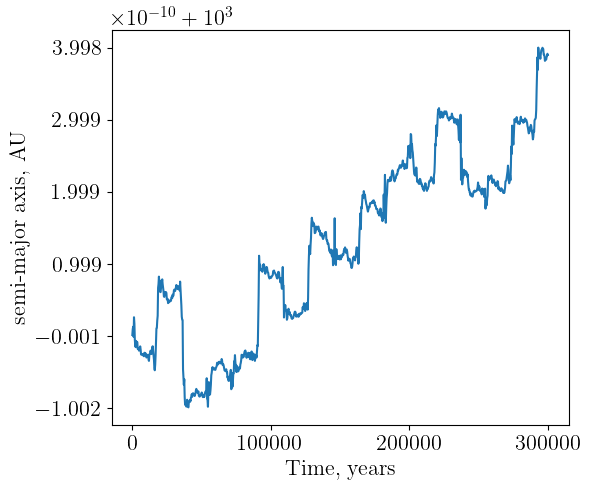

In [13]:
# energy conservation and SMA:
kin_energy=0.5*(vxyz[:,0]**2+vxyz[:,1]**2+vxyz[:,2]**2)
pot_energy=-ps[0].m/np.sqrt(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)
sma=-ps[0].m/(2*(kin_energy+pot_energy))

fig=plt.figure()
plt.plot(itimes/tunit, sma)
plt.xlabel('Time, years')
plt.ylabel('semi-major axis, AU')
#plt.title('semi-major axis')
fig.tight_layout()
plt.show()

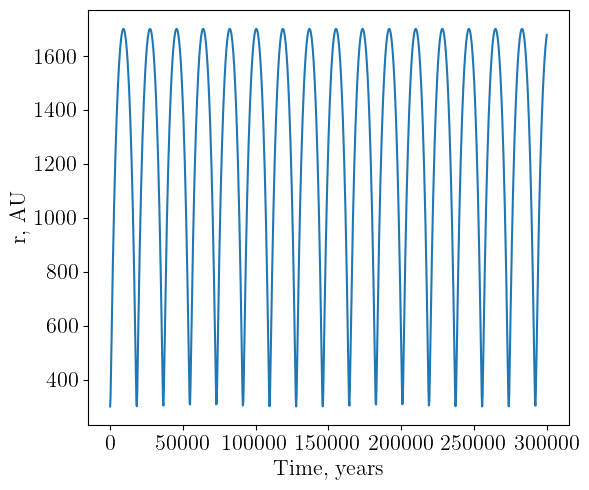

In [14]:
r=np.sqrt(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)

fig=plt.figure()
plt.plot(itimes/tunit, r)
plt.xlabel('Time, years')
plt.ylabel('r, AU')
#plt.title('radius-vector')
fig.tight_layout()
plt.show()
# it does show up with the correct period and even the correct phase... 
# there are 16.5 periods and the total duration is 3e5, so the period is 18 Kyr. 

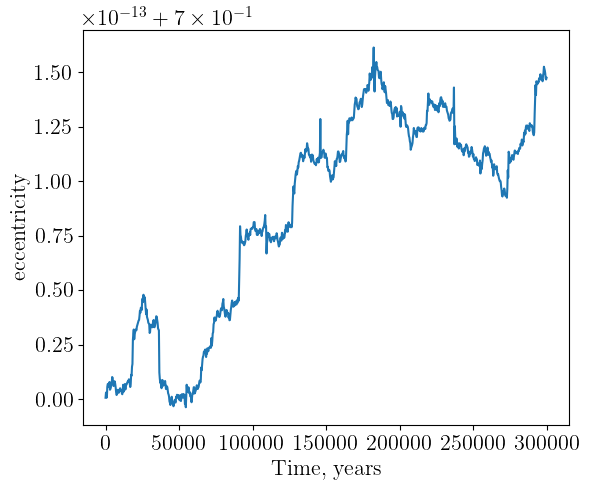

In [15]:
# conservation of angular momentum and eccentricity
ang_momentum=np.sqrt((xyz[:,1]*vxyz[:,2]-xyz[:,2]*vxyz[:,1])**2+(xyz[:,2]*vxyz[:,0]-xyz[:,0]*vxyz[:,2])**2+
                     (xyz[:,0]*vxyz[:,1]-xyz[:,1]*vxyz[:,0])**2)
ecc=np.sqrt(1.-ang_momentum**2/(ps[0].m*sma))

fig=plt.figure()
plt.plot(itimes/tunit, ecc)
plt.xlabel('Time, years')
plt.ylabel('eccentricity')
#plt.title('eccentricity')
fig.tight_layout()
plt.show()

<h2>The test case of the circular orbit and the drag force proportional to velocity, can be solved analytically:</h2>
<p>Equation of motion is: $\ddot{\vec{r}}=-\frac{Gm}{r^2}\hat{r}-\kappa\dot{\vec{r}}.$
<p>We can multiply both sides by $\dot{\vec{r}}$ and obtain ${\rm d}E/{\rm d}t=-\kappa\dot{\vec{r}}^2.$ <b>For a circular orbit,</b> $\dot{\vec{r}}^2=-2E,$ so this is $\dot{E}=2\kappa E,$ which has the solution $E=E_0 e^{2\kappa t}.$ (This should still be true in the orbit-averaged sense for any eccentricity if kappa is small enough.) 
<p><b>For any eccentricity:</b> writing the asimuthal component of the equation of motion in the polar coordinates, $r \ddot{\varphi}+2\dot{r}\dot{\varphi}=-\kappa r \dot{\varphi}.$ Multiplying by $r$ and remembering that $J=r^2\dot{\varphi}$ is the specific angular momentum, we get $\dot{J}=-\kappa J$, which has the solution $J=J_0 e^{-\kappa t}$. 

In [16]:
# this is the coefficient in code units that should give me e^1 increase in binding energy according to the 
# analytical solution
kappa=1/(2*tintegrate*tunit)

In [17]:
# following this example: 
# https://github.com/hannorein/rebound/blob/main/python_examples/dragforce/problem.py
# Import the rebound module 
import rebound

# Add particles
# We work in units where G=1.  
sim = rebound.Simulation()
sim.add(m=total_mass)                  # Stationary center of mass
sim.add(m=0., a=1000., e=0) # moving object

ps = sim.particles


In [18]:
def drag(reb_sim):
    ps[1].ax += -kappa*ps[1].vx
    ps[1].ay += -kappa*ps[1].vy
    ps[1].az += -kappa*ps[1].vz

# Tell rebound which function to call
sim.additional_forces = drag


In [19]:
#sim.integrator = "hermes" 
sim.integrator="whfast"
sim.dt = 1.

# Next, let's do the simulation. This is the max time in code units
t_max = tintegrate*tunit
# the number of times we record is determined by the timestep
itimes = np.arange(0,(t_max+timestep*tunit),timestep*tunit)
nstep=np.size(itimes)
xyz = np.zeros((nstep, 3))
vxyz = np.zeros((nstep, 3))
for i, itime in enumerate(itimes):
    sim.integrate(itime)
    ps=sim.particles
    xyz[i] = [ps[1].x, ps[1].y, ps[1].z]
    vxyz[i] = [ps[1].vx, ps[1].vy, ps[1].vz]


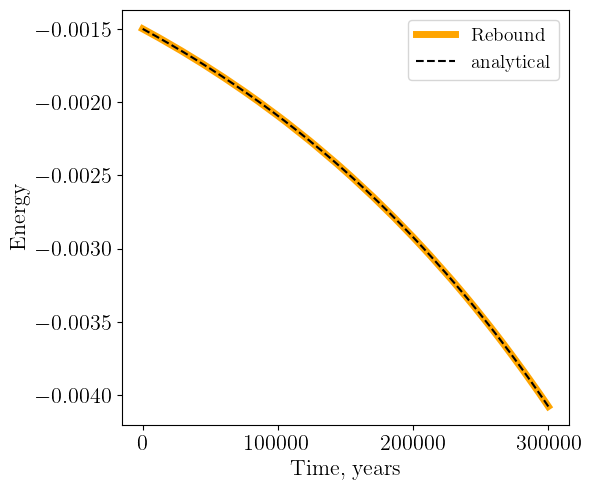

In [20]:
kin_energy=0.5*(vxyz[:,0]**2+vxyz[:,1]**2+vxyz[:,2]**2)
pot_energy=-ps[0].m/np.sqrt(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)
energy=kin_energy+pot_energy

fig=plt.figure()
plt.plot(itimes/tunit, energy, color='orange', linewidth=5, label='Rebound')
plt.plot(itimes/tunit, energy[0]*np.exp(2*kappa*itimes),color='black',linestyle='dashed', label='analytical')
plt.xlabel('Time, years')
plt.ylabel('Energy')
#plt.title('energy')
plt.legend(loc="upper right")
fig.tight_layout()
plt.show()

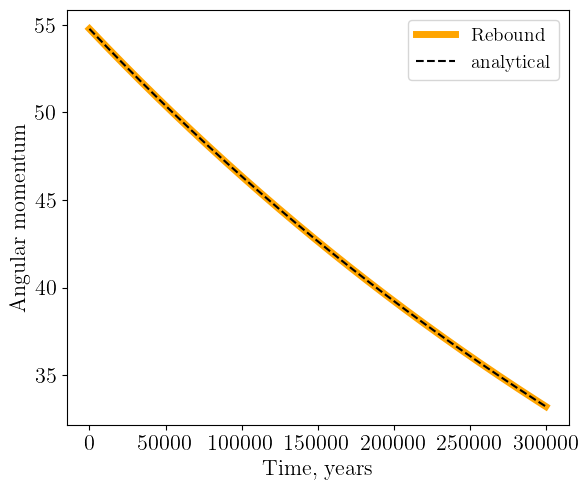

In [21]:
ang_momentum=np.sqrt((xyz[:,1]*vxyz[:,2]-xyz[:,2]*vxyz[:,1])**2+(xyz[:,2]*vxyz[:,0]-xyz[:,0]*vxyz[:,2])**2+
                     (xyz[:,0]*vxyz[:,1]-xyz[:,1]*vxyz[:,0])**2)

fig=plt.figure()
plt.plot(itimes/tunit, ang_momentum, color='orange', linewidth=5, label='Rebound')
plt.plot(itimes/tunit, ang_momentum[0]*np.exp(-kappa*itimes),color='black',linestyle='dashed', label='analytical')
plt.xlabel('Time, years')
plt.ylabel('Angular momentum')
#plt.title('angular momentum')
plt.legend(loc="upper right")
fig.tight_layout()
plt.show()

<h2>The case of m=const, ak!=0. According to analytical theory, should conserve Delaunay actions L and Jz, not not J which is the specific angular momentum. </h2>
<p>Equation of motion is: $\ddot{\vec{r}}=-\frac{Gm}{r^2}\hat{r}+\vec{a}_k.$
<p>We can multiply both sides by $\dot{\vec{r}}$ and obtain ${\rm d}E/{\rm d}t=\vec{a}_k\cdot\dot{\vec{r}}$. If the acceleration is constant in time, this can be integrated with $E=E_0+\vec{a}_k\left(\vec{r}-\vec{r}_0\right).$
<p>In our setup, we assume that $\vec{a}_k$ is something that's intrinsic to the star (likely due to the direction of its rotational angular momentum), so we fix the $z$ axis along this direction and define orbital elements relative to that. 

In [22]:
vkick=2.0
tintegrate=3e5 # time in years 
timestep=3e2 # this is not the integration time step, it's the dumping time step

In [23]:
# following this example: 
# https://github.com/hannorein/rebound/blob/main/python_examples/dragforce/problem.py
# Import the rebound module 
import rebound

# Add particles
# We work in units where G=1.  
sim = rebound.Simulation()
sim.add(m=total_mass)                  # Stationary center of mass
sim.add(m=0., a=ain, e=eccin, inc=incin, Omega=asclong, omega=omegain, M=0.) # moving object

ps = sim.particles


In [24]:
ps[1]


<rebound.particle.Particle object at 0x16958afd0, m=0.0 x=259.8076211353316 y=-6.609558772983111e-14 z=149.99999999999997 vx=3.086526572276924e-17 vy=0.130384048104053 vz=3.9918601792625746e-18>

In [25]:
def ak(reb_sim):
    ak_physical=vkick/tintegrate #in km/sec over 3e5 years
    ak_code=ak_physical*aunit
    ps[1].az += ak_code

# Tell rebound which function to call
sim.additional_forces = ak


In [26]:
#sim.integrator = "hermes" 
sim.integrator="whfast"
sim.dt = 1.

# Next, let's do the simulation. This is the max time in code units
t_max = tintegrate*tunit
# the number of times we record is determined by the timestep
itimes = np.arange(0,(t_max+timestep*tunit),timestep*tunit)
nstep=np.size(itimes)
xyz = np.zeros((nstep, 3))
vxyz = np.zeros((nstep, 3))
for i, itime in enumerate(itimes):
    sim.integrate(itime)
    ps=sim.particles
    xyz[i] = [ps[1].x, ps[1].y, ps[1].z]
    vxyz[i] = [ps[1].vx, ps[1].vy, ps[1].vz]


In [27]:
# using the orbital_from_cart(m,r,v) function from orbital.py, calculate instantaneous orbital elements
# from the Rebound solution at every dump step:
fsma,fecc,finc,fasclong,fomega,frue=orbital.orbital_from_cart(ps[0].m,xyz,vxyz)
print(np.shape(finc),np.shape(fsma),np.shape(fecc))

(1001,) (1001,) (1001,)


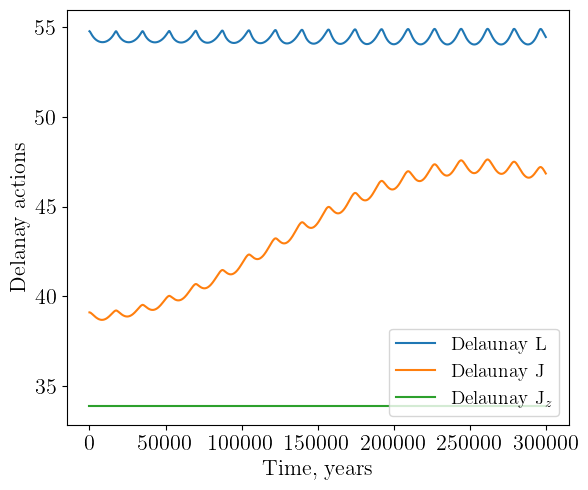

In [28]:
del_L=np.sqrt(ps[0].m*fsma)
del_J=del_L*np.sqrt(1-fecc**2)
del_Jz=del_J*np.cos(finc)

fig=plt.figure()
plt.plot(itimes/tunit, del_L, label='Delaunay L')
plt.plot(itimes/tunit, del_J, label='Delaunay J')
plt.plot(itimes/tunit, del_Jz, label=r'Delaunay J$_z$')
plt.xlabel('Time, years')
plt.ylabel('Delanay actions')
#plt.title('semi-major axis')
plt.legend(loc="lower right")
fig.tight_layout()
plt.show()
# for the Delaunay L to oscillate on the timescale of the orbital period is fine because it's 
# only conserved in the orbit-averaged sense

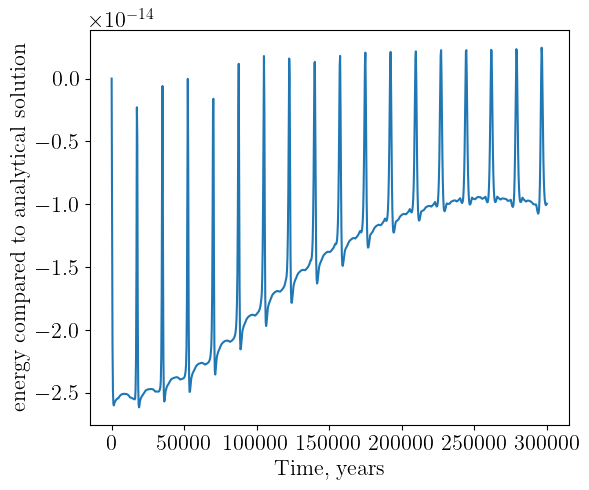

In [29]:
# Energy conservation
fen=-0.5*ps[0].m/fsma
ak_physical=vkick/tintegrate #in km/sec over 3e5 years
ak_code=ak_physical*aunit
fig=plt.figure()
plt.plot(itimes/tunit, fen-fen[0]-ak_code*(xyz[:,2]-xyz[0,2]))
plt.xlabel('Time, years')
plt.ylabel('energy compared to analytical solution')
fig.tight_layout()
plt.show()


<h2>Let's solve the same problem using the Hamiltonian approach and compare direct Rebound integration with the Hamiltonian orbit-averaged solutions</h2>
<p>We are solving the following differential equations:
$$\frac{{\rm d}\omega}{{\rm d} t}=\frac{\partial H_1}{\partial J};$$
$$\frac{{\rm d}J}{{\rm d} t}=-\frac{\partial H_1}{\partial \omega},$$
with the right hand sides explicitly calculable from the Hamiltonian in Delaunay variables:
$$H_1=-\dot{v}_k\frac{3L^2}{2Gm}\sqrt{1-\frac{J^2}{L^2}}\sqrt{1-\frac{J_z^2}{J^2}}\sin\omega.$$
The remaining Hamiltonian equations are 
$$\frac{{\rm d}\Omega}{{\rm d} t}=\frac{\partial H_1}{\partial J_z};\frac{{\rm d}J_z}{{\rm d} t}=-\frac{\partial H_1}{\partial \Omega}=0$$
and
$$\frac{{\rm d}M}{{\rm d} t}=\frac{\partial H_1}{\partial L};\frac{{\rm d}L}{{\rm d} t}=-\frac{\partial H_1}{\partial M}=0,$$    
so that $J_z=\sqrt{Gma(1-e^2)}\cos i$ and $L=\sqrt{Gma}$ are conserved. 

In [30]:
# initial conditions:
ak_physical=vkick/tintegrate # constant acceleration
ak_code=ak_physical*aunit # this is in code units
# this is the Delaunay variable L, which is constant:
Lin=np.sqrt(total_mass*ain)
# this is the Delaunay variable J, which is the angular momentum, which is not const:
Jin=Lin*np.sqrt(1-eccin**2)
# this is the Delaunay variable Jz, which is the z component of the angular momentum, which is const:
Jzin=Jin*np.cos(incin)

In [31]:
inst_J=np.cross(xyz[0,:],vxyz[0,:])
mag_J=np.sqrt(np.sum(inst_J**2))
print('z component of angular momentum two approaches', Jzin, xyz[0,0]*vxyz[0,1]-xyz[0,1]*vxyz[0,0])
print('total angular momentum', Jin, mag_J)

z component of angular momentum two approaches 33.87476937190864 33.87476937190865
total angular momentum 39.11521443121589 39.1152144312159


In [32]:
import time
from scipy.integrate import solve_ivp

In [33]:
t0 = time.time()
def ak(t):
# acceleration in code units
    return(ak_code)
def tm(t):
    return(total_mass)
# we determine the number of intergration steps:
temp_steps=100
# number of integration steps per precession period is 10 here
deltat_code=np.sqrt(total_mass/ain)/ak_code/temp_steps
# this is the total number of steps: 
nsteps=max(temp_steps, int(tintegrate*tunit/deltat_code))
t_eval=np.linspace(0, tintegrate*tunit, nsteps)
# RHS for the system of diff eq for J and omega:
def rhs(t, v): 
    tol=1.e-14
    par1=max(tol,1-v[0]**2/Lin**2)
    par2=max(tol,1-Jzin**2/v[0]**2)
    return [-ak(t)*np.cos(v[1])*1.5*np.sqrt(par1)*Lin**2/tm(t)*np.sqrt(par2),
       ak(t)*1.5*Lin**2*np.sin(v[1])*(Jzin**2/v[0]**3-v[0]/Lin**2)/(tm(t)*np.sqrt(par1)*np.sqrt(par2))]
res = solve_ivp(rhs, (0, tintegrate*tunit), [Jin, omegain], t_eval=t_eval)
t1 = time.time()
print('execution time, sec ', t1-t0)

execution time, sec  0.0016069412231445312


In [34]:
ham_inc=np.arccos(Jzin/res.y[0])
ham_ecc=np.sqrt(1-res.y[0]**2/Lin**2)
ham_J=res.y[0]
ham_omega=res.y[1]

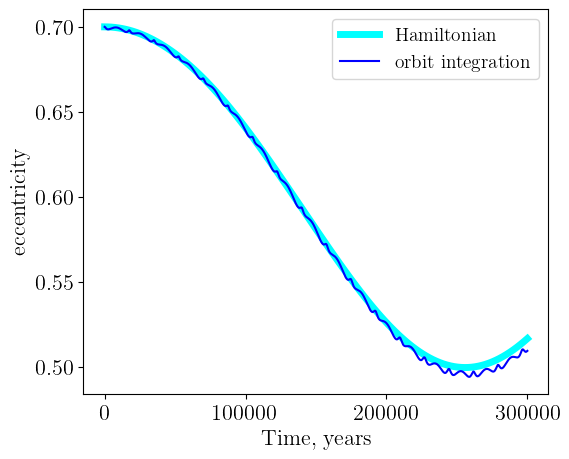

In [35]:
plt.figure()
plt.plot(res.t/tunit, ham_ecc, color='cyan', linewidth=5, label='Hamiltonian')
plt.plot(itimes/tunit, fecc, color='blue', label='orbit integration')
plt.legend(loc='upper right')
plt.xlabel('Time, years')
plt.ylabel('eccentricity')
fig.tight_layout()
plt.show()


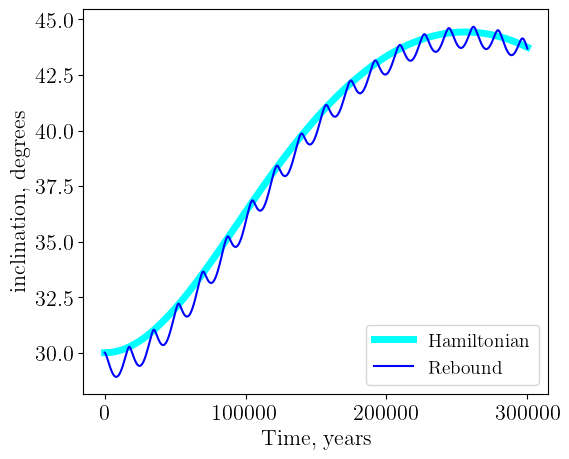

In [36]:
plt.figure()
plt.plot(res.t/tunit, ham_inc*180./np.pi, color='cyan', linewidth=5, label='Hamiltonian')
plt.plot(itimes/tunit, finc*180./np.pi, color='blue', label='Rebound')
plt.legend(loc='lower right')
plt.xlabel('Time, years')
plt.ylabel('inclination, degrees')
fig.tight_layout()
plt.show()

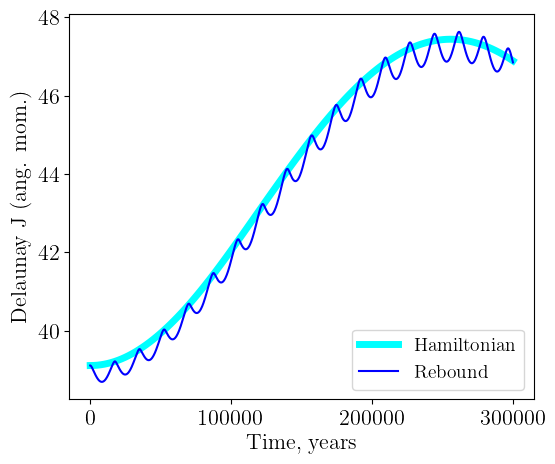

In [37]:
# let's plot the actual integration value, which is Delaunay J:
plt.figure()
plt.plot(res.t/tunit, ham_J, color='cyan', linewidth=5, label='Hamiltonian')
plt.plot(itimes/tunit, del_J, color='blue', label='Rebound')
plt.legend(loc='upper right')
plt.xlabel('Time, years')
plt.ylabel('Delaunay J (ang. mom.)')
plt.legend(loc='lower right')
fig.tight_layout()
plt.show()

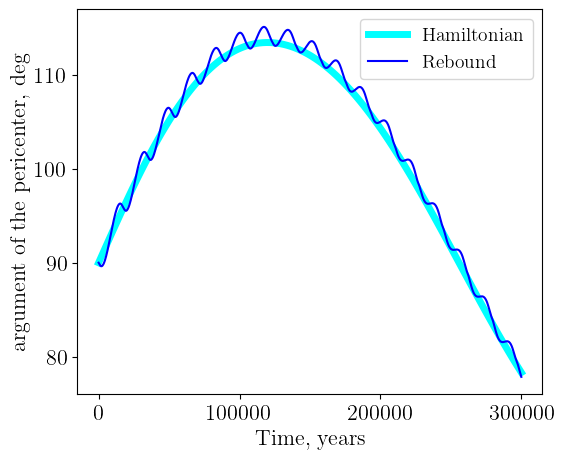

In [38]:
plt.figure()
plt.plot(res.t/tunit, ham_omega*180/np.pi, color='cyan', linewidth=5, label='Hamiltonian')
plt.plot(itimes/tunit, fomega*180/np.pi, color='blue', label='Rebound')
plt.legend(loc='upper right')
plt.xlabel('Time, years')
plt.ylabel('argument of the pericenter, deg')
fig.tight_layout()
plt.show()

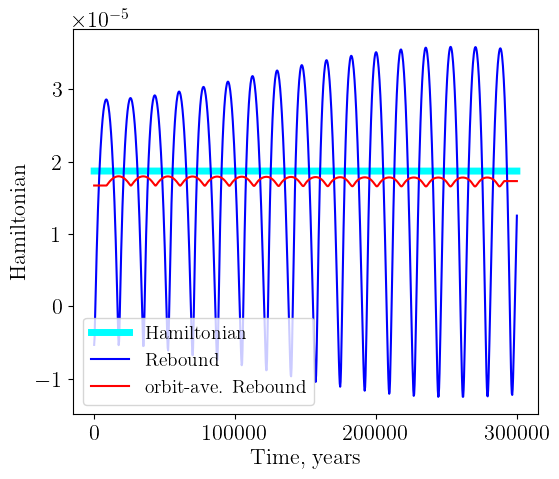

In [39]:
# Hamiltonian! 
hamiltonian=ak_code*1.5*np.sqrt(1-res.y[0]**2/Lin**2)*Lin**2/ps[0].m*np.sin(res.y[1])*np.sqrt(1-Jzin**2/res.y[0]**2)
plt.figure()
plt.plot(res.t/tunit, hamiltonian, color='cyan', linewidth=5, label='Hamiltonian')
plt.plot(itimes/tunit, -ak_code*(xyz[:,2]), color='blue', label="Rebound")
plt.plot(itimes/tunit, scipy.signal.savgol_filter(-ak_code*(xyz[:,2]),int(orbital.per(3.,1e3)/timestep),0), color='red', label="orbit-ave. Rebound")
plt.legend(loc='lower left')
plt.xlabel('Time, years')
plt.ylabel('Hamiltonian')
fig.tight_layout()
plt.show()

<h2>Now moving away from the integrations of a particular system, let's think a little about the general properties of the Stark problem (constant acceleration)</h2>
<p>The properties of the solution for a hamiltonian that doesn't explicitly depend on time are very similar to those desribed by <a href="https://ui.adsabs.harvard.edu/abs/2022ApJ...929L..29H/abstract">C. Hamilton</a>, where in the tidal potential of the Galaxy, $\Gamma=const$ also results in the system moving on loops in the same space of Delaunay actions. 

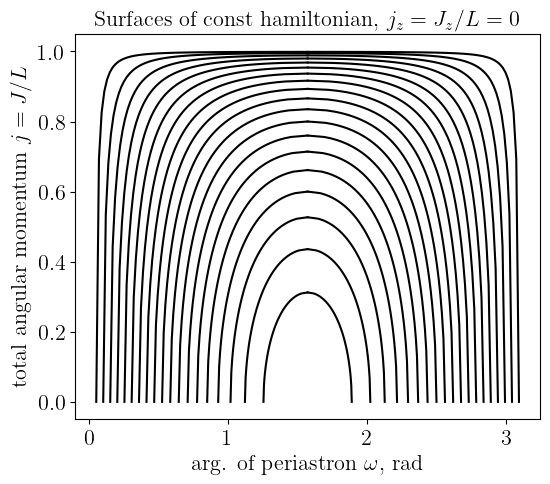

In [40]:
# OK, Hamiltonian is conserved, so the object moves on a contour. Let's say Jz=0, what's the shape of the contours?
Kvalues=np.arange(0.05,1.0,0.05)
mysteps=50
for K in Kvalues:
    x=np.linspace(K,1,mysteps)
    plt.plot(np.arcsin(x),np.sqrt(1-(K/x)**2),color='black')
    plt.plot(np.pi-np.arcsin(x),np.sqrt(1-(K/x)**2),color='black')
plt.xlabel(r'arg. of periastron $\omega$, rad')
plt.ylabel(r'total angular momentum $j=J/L$')
plt.title(r'Surfaces of const hamiltonian, $j_z=J_z/L=0$')
plt.show()

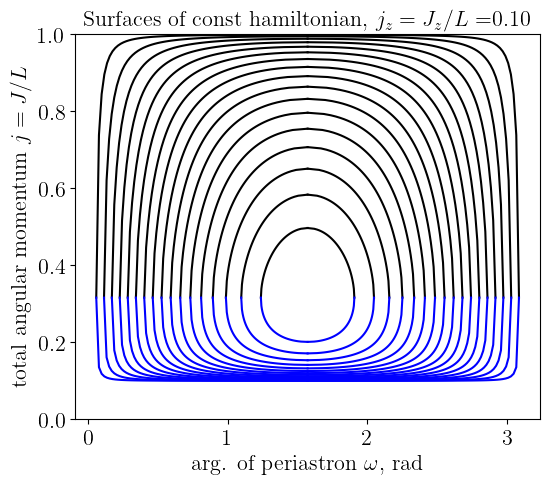

In [41]:
# now Jz is not 0
jz=0.1
Kvalues=np.arange(0.05,1.0-jz,0.05) # this is actually linearly spaced energy
mysteps=50
for K in Kvalues:
    x=np.linspace(K/(1-jz),1,mysteps)
    discr=(1+jz**2-(K/x)**2)**2-4*jz**2
    ind=(np.abs(discr)<1e-8)
    discr[ind]=0.0
    ind=(discr<0)
    if (len(x[ind])>0): print('Houston, we have a problem', K, x[ind], discr[ind])
    j1=np.sqrt(0.5*((1+jz**2-(K/x)**2)+np.sqrt(discr)))
    j2=np.sqrt(0.5*((1+jz**2-(K/x)**2)-np.sqrt(discr)))
    plt.plot(np.arcsin(x),j1,color='black')
    plt.plot(np.pi-np.arcsin(x),j1,color='black')
    plt.plot(np.arcsin(x),j2,color='blue')
    plt.plot(np.pi-np.arcsin(x),j2,color='blue')
plt.xlabel(r'arg. of periastron $\omega$, rad')
plt.ylabel(r'total angular momentum $j=J/L$')
plt.ylim((0.,1.))
plt.title(r'Surfaces of const hamiltonian, $j_z=J_z/L=$%0.2f' % (jz))
plt.show()

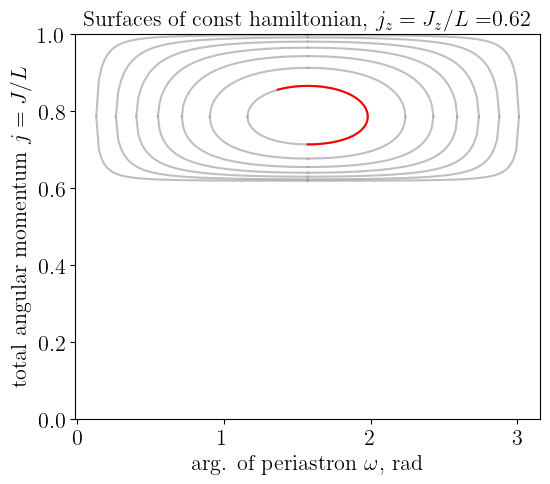

In [42]:
# let's do this plot for our specific system:
jz=Jzin/Lin
Kvalues=np.arange(0.05,1.0-jz,0.05) # this is actually linearly spaced energy
mysteps=50
for K in Kvalues:
    x=np.linspace(K/(1-jz),1,mysteps)
    discr=(1+jz**2-(K/x)**2)**2-4*jz**2
    ind=(np.abs(discr)<1e-8)
    discr[ind]=0.0
    ind=(discr<0)
    if (len(x[ind])>0): print('Houston, we have a problem', K, x[ind], discr[ind])
    j1=np.sqrt(0.5*((1+jz**2-(K/x)**2)+np.sqrt(discr)))
    j2=np.sqrt(0.5*((1+jz**2-(K/x)**2)-np.sqrt(discr)))
    plt.plot(np.arcsin(x),j1,color='grey',alpha=0.5)
    plt.plot(np.pi-np.arcsin(x),j1,color='grey',alpha=0.5)
    plt.plot(np.arcsin(x),j2,color='grey',alpha=0.5)
    plt.plot(np.pi-np.arcsin(x),j2,color='grey',alpha=0.5)
plt.plot(ham_omega, ham_J/Lin, color='red')
plt.xlabel(r'arg. of periastron $\omega$, rad')
plt.ylabel(r'total angular momentum $j=J/L$')
plt.ylim((0.,1.))
plt.title(r'Surfaces of const hamiltonian, $j_z=J_z/L=$%0.2f' % (jz))
plt.show()